In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os
import sys
import sqlalchemy as sa

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    

load_dotenv()

True

In [2]:
from keras.models import load_model

model_view = load_model('../model/c-view.keras')
model_cart = load_model('../model/c-cart.keras')
model_remove_from_cart = load_model('../model/c-remove_from_cart.keras')
model_purchase = load_model('../model/c-purchase.keras')

In [3]:
conn_string = 'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/cosmetic'.format(
    db_user=os.getenv('DB_USER'),
    db_password=os.getenv('DB_PASSWORD'),
    db_host=os.getenv('DB_HOST'),
    db_port=os.getenv('DB_PORT'),
)
engine = sa.create_engine(conn_string)

In [4]:
import datetime

start = datetime.date(2019, 11, 24)
end = datetime.date(2019, 11, 25)

In [5]:
from collections import defaultdict
from sqlalchemy import orm
import random

from schemas.product import Product
from schemas.data_by_date import DataByDate
from utils.utils import date_range, data_descale, preprocess_c

prev_days = int(os.getenv('PREV_DAYS'))

with orm.Session(engine) as session, session.begin():
    products = dict[tuple[int, int], Product]()
    for row in session.scalars(sa.select(Product)).all():
        products[(row.product_id, row.category_id)] = row
    
    memorized = defaultdict(lambda: defaultdict(lambda: { 'view': 0, 'cart': 0, 'remove_from_cart': 0, 'purchase': 0 }))

    d = start - datetime.timedelta(days=prev_days)
    for i in range(prev_days):
        for row in session.scalars(sa.select(DataByDate).where(DataByDate.date == d).order_by(DataByDate.rank.asc())):
            key = (row.product_id, row.category_id)
            memorized[d][key] = {
                'view': row.view,
                'cart': row.cart,
                'remove_from_cart': row.remove_from_cart,
                'purchase': row.purchase,
            }

        d += datetime.timedelta(days=1)
    
    while d < end:
        print(d)
        records = list[dict]()

        rows = list[dict]()
        categories = defaultdict(lambda: list[dict]())
        for row in session.scalars(sa.select(DataByDate).where(DataByDate.date == d).order_by(DataByDate.rank.asc())):
            key = (row.product_id, row.category_id)
            record = {
                'product_id': row.product_id,
                'category_id': row.category_id,
                'old_rank': row.rank,
                'old_rank_in_category': row.rank_in_category,
                'view': row.view,
                'cart': row.cart,
                'remove_from_cart': row.remove_from_cart,
                'purchase': row.purchase,
                'rank': 0,
                'rank_in_category': 0,
                'days_on_shelf': (d - products[key].release_date).days,
                'price': row.max_price,
            }

            rows.append(record)
            categories[row.category_id].append(record)

        
        def key_func(record: dict):
            key = (record['product_id'], record['category_id'])
            prev_sales = sum(memorized[p][key]['purchase'] for p in date_range(d - datetime.timedelta(days=30), d, datetime.timedelta(days=1)))
            prev_views = max(1, sum(memorized[p][key]['view'] for p in date_range(d - datetime.timedelta(days=30), d, datetime.timedelta(days=1))))
            return -prev_sales, record['days_on_shelf'], record['price']
        
        for category in categories.values():
            category.sort(key=key_func)
            for index, record in enumerate(category):
                record['rank_in_category'] = 1000

        rows.sort(key=key_func)      
        
        for index, record in enumerate(rows):
            record['rank'] = 10000

            key = (record['product_id'], record['category_id'])

            for i in range(1, prev_days + 1):
                prev_d = d - datetime.timedelta(days=i)
                record[f'view_prev{i}'] = memorized[prev_d][key]['view']
                record[f'cart_prev{i}'] = memorized[prev_d][key]['cart']
                record[f'remove_from_cart_prev{i}'] = memorized[prev_d][key]['remove_from_cart']
                record[f'purchase_prev{i}'] = memorized[prev_d][key]['purchase']

            if (d - products[key].release_date).days >= 7:
                records.append(record)
            else:
                memorized[d][key] = {
                    'view': record['view'],
                    'cart': record['cart'],
                    'remove_from_cart': record['remove_from_cart'],
                    'purchase': record['purchase'],
                }
        
        del memorized[d - datetime.timedelta(days=prev_days)]

        df = pd.DataFrame.from_records(records)
        result_df = df.loc[:,[
            'product_id', 
            'category_id',
            'old_rank',
            'old_rank_in_category',
            'rank',
            'rank_in_category',
            'view', 
            'cart', 
            'remove_from_cart', 
            'purchase', 
        ]]
        df = df.drop(columns=['product_id', 'category_id', 'old_rank', 'old_rank_in_category'])
        X1, X2, y = preprocess_c(df)
        result_df['predicted_view'] = data_descale(model_view.predict([X1, X2])[:, 0], 'view')
        result_df['predicted_cart'] = data_descale(model_cart.predict([X1, X2])[:, 0], 'cart')
        result_df['predicted_remove_from_cart'] = data_descale(model_remove_from_cart.predict([X1, X2])[:, 0], 'remove_from_cart')
        result_df['predicted_purchase'] = data_descale(model_purchase.predict([X1, X2])[:, 0], 'purchase')

        
        name = d.strftime('%Y-%m-%d')
        result_df.to_csv(f'../.data/ranking/d-{name}.csv')
        for result in result_df.to_dict('records'):
            key = (result['product_id'], result['category_id'])
            memorized[d][key] = {
                'view': result['predicted_view'],
                'cart': result['predicted_cart'],
                'remove_from_cart': result['predicted_remove_from_cart'],
                'purchase': result['predicted_purchase'],
            }

        d += datetime.timedelta(days=1)        

2019-11-24
610/610 [==============================] - 1s 973us/step


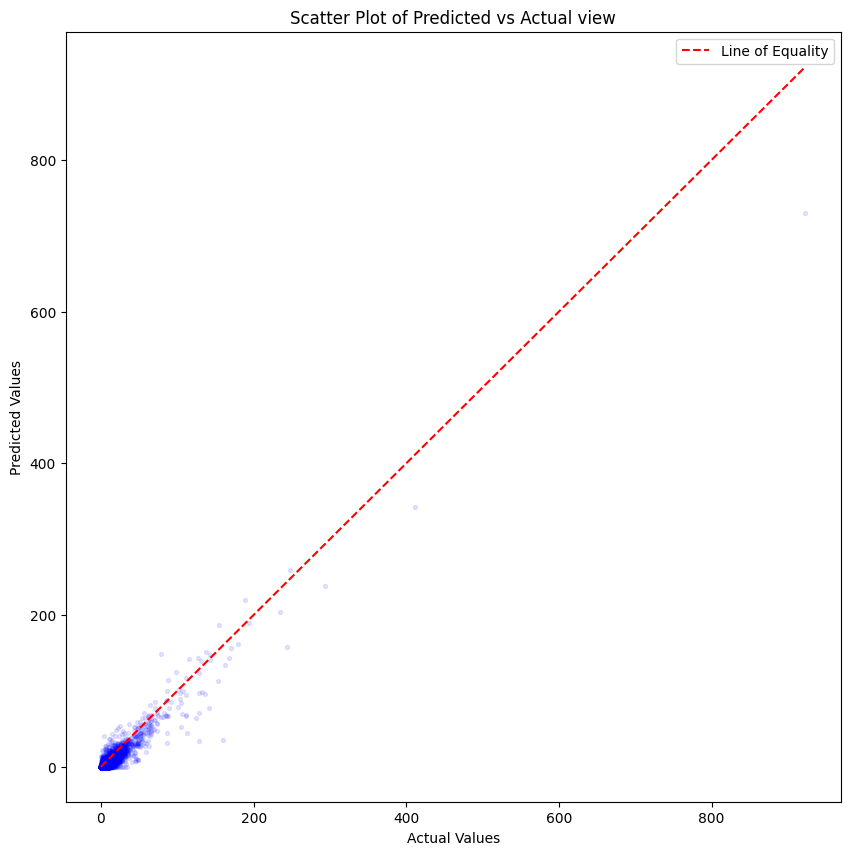

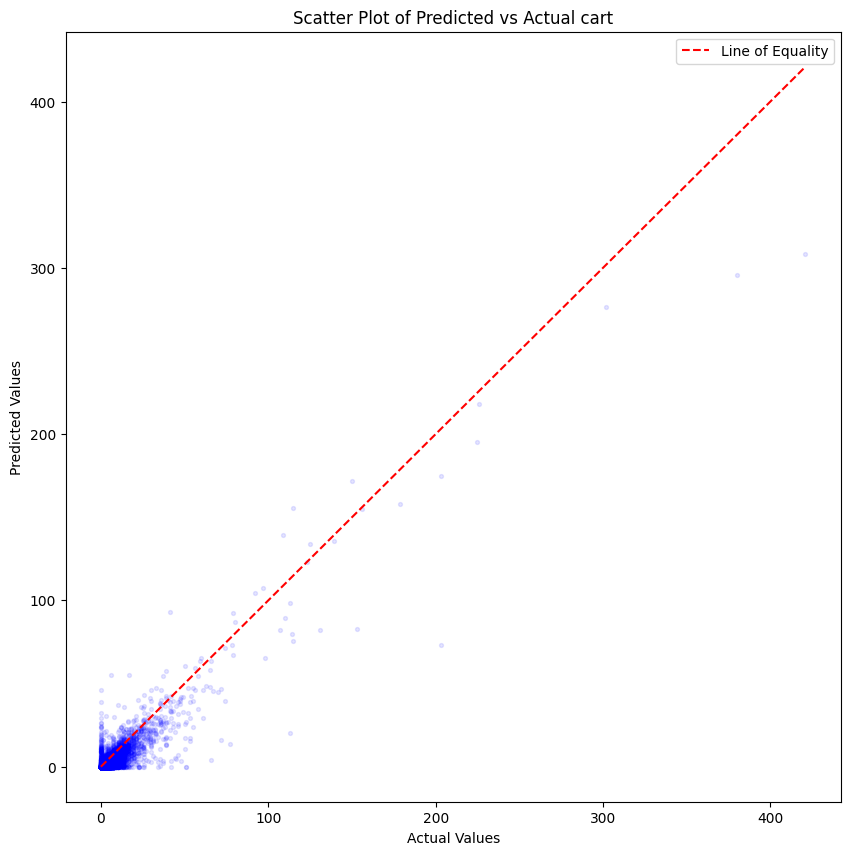

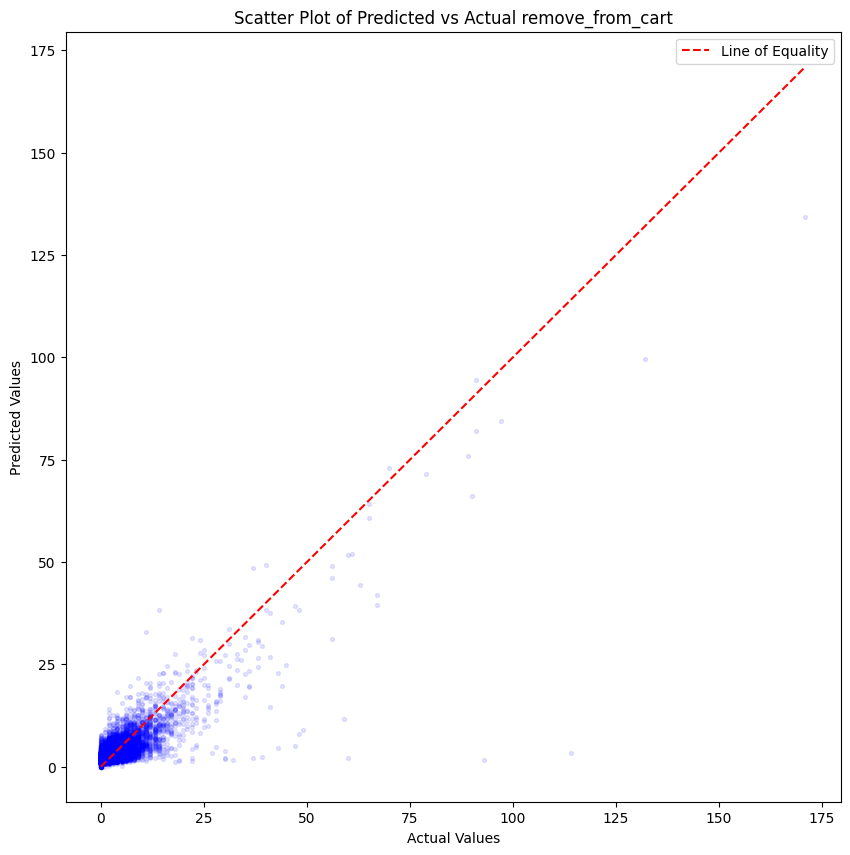

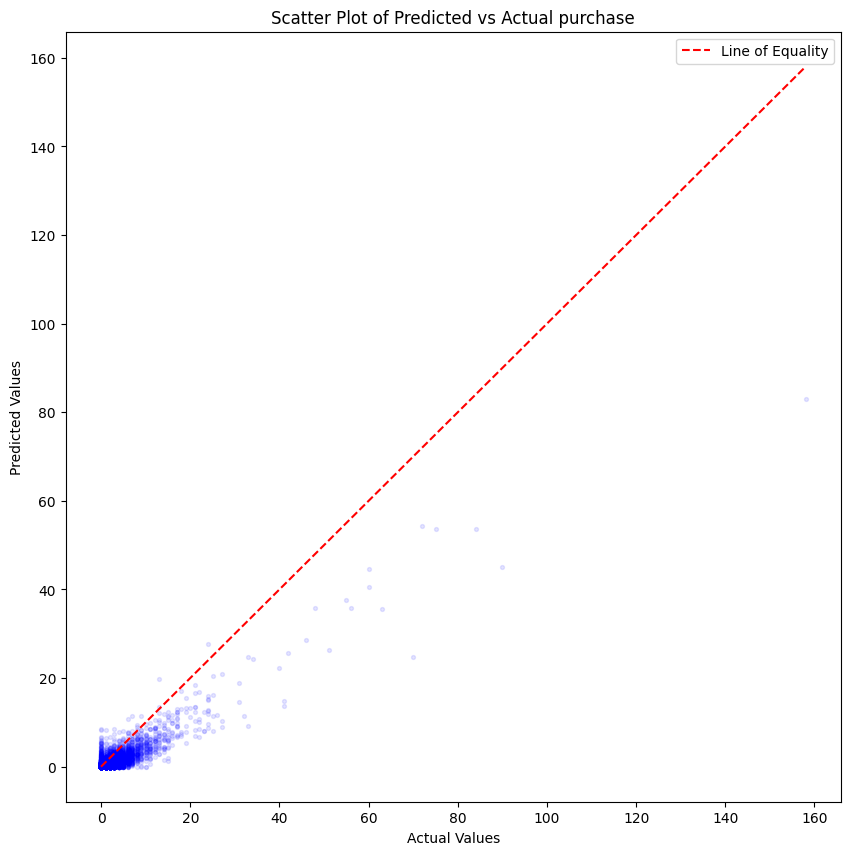

In [9]:
from utils.utils import plot_accuracy

result_df = pd.concat([
    pd.read_csv(f'../.data/ranking/d-{d.strftime("%Y-%m-%d")}.csv') for d in date_range(
        start,
        end,
        datetime.timedelta(days=1)
    )
])


plot_accuracy(result_df['predicted_view'], result_df['view'], 'view')
plot_accuracy(result_df['predicted_cart'], result_df['cart'], 'cart')
plot_accuracy(result_df['predicted_remove_from_cart'], result_df['remove_from_cart'], 'remove_from_cart')
plot_accuracy(result_df['predicted_purchase'], result_df['purchase'], 'purchase')

In [7]:
result_df

,Unnamed: 0,product_id,category_id,rank,rank_in_category,view,cart,remove_from_cart,purchase,predicted_view,predicted_cart,predicted_remove_from_cart,predicted_purchase
0,0,5809910,1602943681873052386,1,1,923,380,171,158,958.82380,305.611900,144.154880,74.649506
1,1,5854897,1487580009445982239,2,1,78,302,97,84,87.10044,264.353000,75.053130,45.685190
2,2,5751422,1487580005268456287,3,1,234,150,91,60,281.27545,154.460140,81.339770,40.603180
3,3,5802432,1487580009286598681,4,1,2,0,14,0,1.24471,4.411281,33.057148,10.740800
4,4,5304,1487580009471148064,5,1,63,139,56,63,94.79172,127.341910,44.353294,30.548801
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19493,19493,5856307,2022622168218599898,19837,1,5,2,0,0,1.24471,-0.025596,-0.009887,-0.003297
19494,19494,5856185,1487580006300255120,19838,64,4,0,0,0,1.24471,-0.026856,-0.009771,-0.003442
19495,19495,4662,1487580006300255120,19839,65,3,0,0,0,1.24471,-0.027323,-0.009567,-0.003587
19496,19496,5888097,1487580013388628160,19840,44,3,1,0,0,1.24471,-0.030282,-0.010250,-0.003935
